In [15]:
import os
import re

import pandas as pd
import rioxarray
import xarray as xr

# Base directory
base_dir = "/home/jovyan/grid4earth_S2L1B/Sentinel-2/MSI/MSI_L1B_GR/2025/07/24"

# Band suffixes of interest
band_ids = [
    "B01",
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B09",
    "B10",
    "B11",
    "B12",
    "B8A",
]

# List SAFE folders
safe_dirs = sorted(
    [
        d
        for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d)) and d.endswith(".11")
    ]
)

# Container for time-stamped datasets
ds_list = []

for safe_name in safe_dirs:
    safe_path = os.path.join(base_dir, safe_name)
    img_data_dir = os.path.join(safe_path, "IMG_DATA")

    print(f"\n📦 Processing: {safe_name}")

    # Extract sensing time from the filename, between "_S" and "_D"
    match = re.search(r"_S(\d{8}T\d{6})_D", safe_name)
    if not match:
        print(f"❌ No timestamp found in {safe_name}")
        continue

    timestamp_str = match.group(1)
    timestamp = pd.to_datetime(timestamp_str, format="%Y%m%dT%H%M%S")

    data_vars = {}
    ref_da = None

    for band in band_ids:
        band_files = [f for f in os.listdir(img_data_dir) if f.endswith(f"{band}.jp2")]
        if not band_files:
            print(f"⚠️  Missing {band} in {safe_name}")
            continue

        path = os.path.join(img_data_dir, band_files[0])
        da = rioxarray.open_rasterio(path, masked=True).squeeze()

        # Use the first band as the shape reference
        if ref_da is None:
            ref_da = da
        # No CRS or reprojection handled here

        data_vars[band] = da

    if not data_vars:
        print("🚫 No bands loaded, skipping.")
        continue

    # Create Dataset and add time as a coordinate
    ds = xr.Dataset(data_vars)
    ds = ds.expand_dims(time=[timestamp])
    ds_list.append(ds)

# Combine all time-stamped datasets
if ds_list:
    ds_all = xr.concat(ds_list, dim="time")
    print("\n✅ Combined dataset with time dimension:")
    print(ds_all)
    # Optionally save:
    # ds_all.to_zarr("Sentinel2_L1B_timeseries.zarr", mode="w")
else:
    print("\n🚫 No datasets to combine.")


📦 Processing: S2A_OPER_MSI_L1B_GR_2APS_20250724T145646_S20250724T112804_D06_N05.11


/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_w


📦 Processing: S2A_OPER_MSI_L1B_GR_2APS_20250724T145646_S20250724T112807_D06_N05.11


/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_w


📦 Processing: S2A_OPER_MSI_L1B_GR_2APS_20250724T145646_S20250724T112808_D07_N05.11


/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_w


📦 Processing: S2A_OPER_MSI_L1B_GR_2APS_20250724T145646_S20250724T112811_D06_N05.11


/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_w


📦 Processing: S2A_OPER_MSI_L1B_GR_2APS_20250724T145646_S20250724T112811_D07_N05.11


/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_w


📦 Processing: S2A_OPER_MSI_L1B_GR_2APS_20250724T145646_S20250724T112815_D07_N05.11


/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_w


📦 Processing: S2A_OPER_MSI_L1B_GR_2APS_20250724T145646_S20250724T112818_D07_N05.11


/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/srv/conda/envs/eopf/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_w


✅ Combined dataset with time dimension:
<xarray.Dataset> Size: 2GB
Dimensions:      (time: 7, y: 2304, x: 2552)
Coordinates:
  * time         (time) datetime64[ns] 56B 2025-07-24T11:28:04 ... 2025-07-24...
  * x            (x) float64 20kB 0.5 1.5 2.5 ... 2.55e+03 2.55e+03 2.552e+03
  * y            (y) float64 18kB 0.5 1.5 2.5 ... 2.302e+03 2.302e+03 2.304e+03
    band         int64 8B 1
    spatial_ref  int64 8B 0
Data variables: (12/13)
    B01          (time, y, x) float32 165MB 377.0 377.0 377.0 ... nan nan nan
    B02          (time, y, x) float32 165MB 292.0 296.0 298.0 ... 299.0 298.0
    B03          (time, y, x) float32 165MB 237.0 235.0 227.0 ... 238.0 244.0
    B04          (time, y, x) float32 165MB 180.0 175.0 180.0 ... 188.0 192.0
    B05          (time, y, x) float32 165MB 176.0 178.0 175.0 ... nan nan nan
    B06          (time, y, x) float32 165MB 159.0 161.0 162.0 ... nan nan nan
    ...           ...
    B08          (time, y, x) float32 165MB 153.0 151.0 150.0 ...

In [16]:
ds_all

<xarray.Dataset> Size: 2GB
Dimensions:      (time: 7, y: 2304, x: 2552)
Coordinates:
  * time         (time) datetime64[ns] 56B 2025-07-24T11:28:04 ... 2025-07-24...
  * x            (x) float64 20kB 0.5 1.5 2.5 ... 2.55e+03 2.55e+03 2.552e+03
  * y            (y) float64 18kB 0.5 1.5 2.5 ... 2.302e+03 2.302e+03 2.304e+03
    band         int64 8B 1
    spatial_ref  int64 8B 0
Data variables: (12/13)
    B01          (time, y, x) float32 165MB 377.0 377.0 377.0 ... nan nan nan
    B02          (time, y, x) float32 165MB 292.0 296.0 298.0 ... 299.0 298.0
    B03          (time, y, x) float32 165MB 237.0 235.0 227.0 ... 238.0 244.0
    B04          (time, y, x) float32 165MB 180.0 175.0 180.0 ... 188.0 192.0
    B05          (time, y, x) float32 165MB 176.0 178.0 175.0 ... nan nan nan
    B06          (time, y, x) float32 165MB 159.0 161.0 162.0 ... nan nan nan
    ...           ...
    B08          (time, y, x) float32 165MB 153.0 151.0 150.0 ... 161.0 162.0
    B09          (time, y, x) float32 165MB 117.0 118.0 117.0 ... nan nan nan
    B10          (time, y, x) float32 165MB 104.0 104.0 104.0 ... nan nan nan
    B11          (time, y, x) float32 165MB 137.0 143.0 143.0 ... nan nan nan
    B12          (time, y, x) float32 165MB 128.0 137.0 132.0 ... nan nan nan
    B8A          (time, y, x) float32 165MB 137.0 146.0 144.0 ... nan nan nan

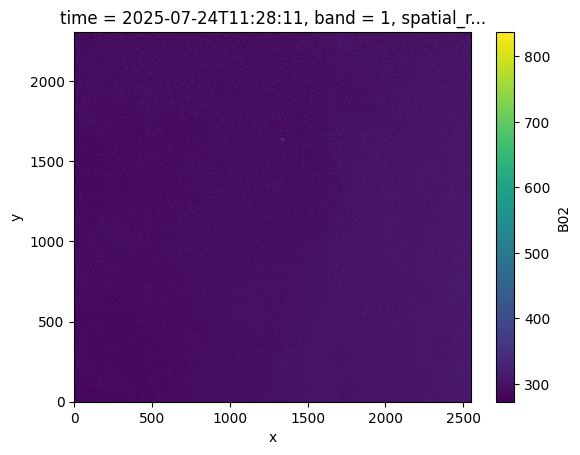

In [20]:
ds_all.B02.isel(time=3).plot()

In [21]:
ds_all.to_zarr("s2l1b_tmp.zarr")

/srv/conda/envs/eopf/lib/python3.11/site-packages/xarray/core/dataset.py:2621: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore[call-overload,misc]
/srv/conda/envs/eopf/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:226: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/srv/conda/envs/eopf/lib/python3.11/site-packages/xarray/core/dataset.py:2621: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore[call-overload,misc]
/srv/conda/envs/eopf/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:226: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [22]:
!du -hs s2l1b_tmp.zarr

242M	s2l1b_tmp.zarr
